
# i2DBSCAN for DEBUGING

### This code works for root files



Filename: ../histograms_Run00046.root
Picname: pic_run00046_ev0
[Image Loaded]
[Pedestal Loaded]
[Edges Calculated]
[3D Method]
[i2DBSCAN Calculated]
[Statistics]
Total number of Clusters: 18
Clusters found in iteration 1: 6
Clusters found in iteration 2: 2
Clusters found in iteration 3: 10
[Plotting ALL iteration]


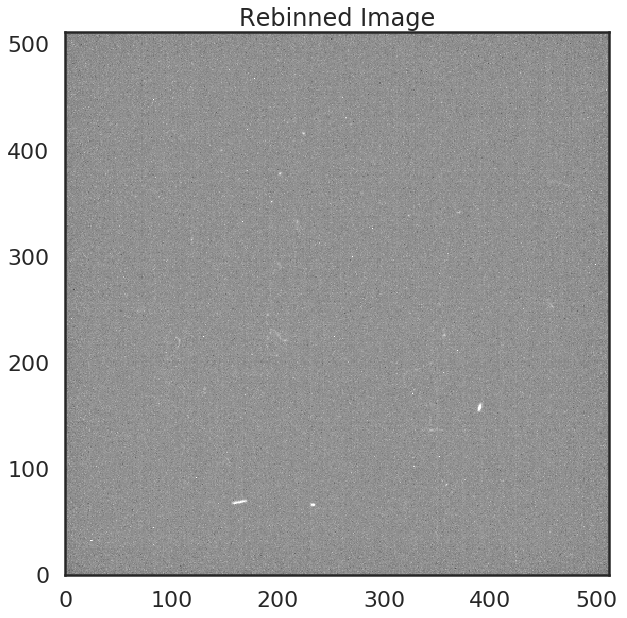

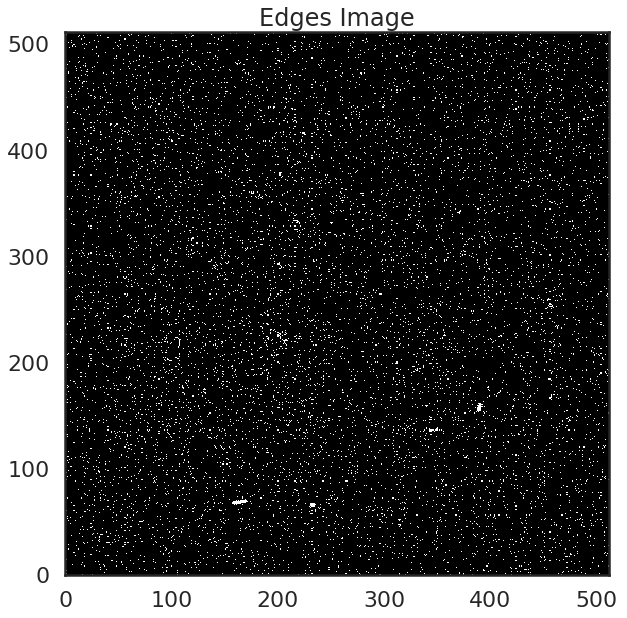

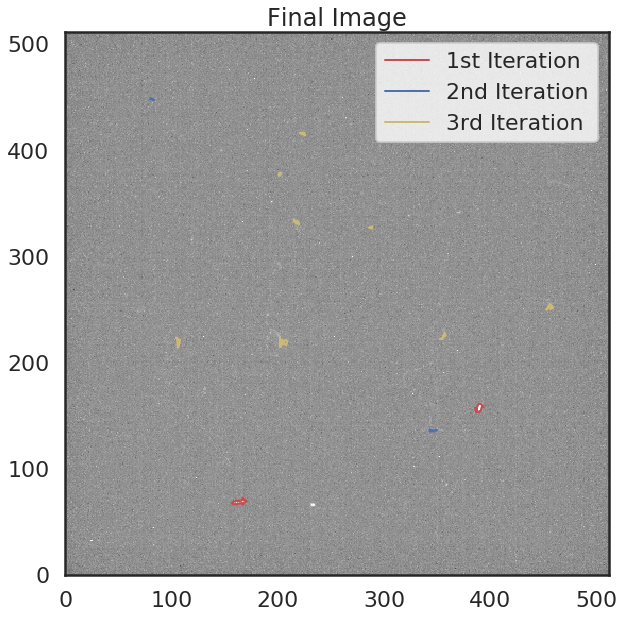

In [11]:
## IMPORTING LIBRARIES

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ROOT
import tools_lib as tl
import sys
sys.path.insert(1, '../')

from iDBSCAN import iDBSCAN
from root_numpy import hist2array
from matplotlib.pyplot import *
from scipy.spatial import distance
from sklearn.cluster import DBSCAN
from sklearn import metrics
from IPython.display import set_matplotlib_formats

%matplotlib inline
## Setting plotting parameters
set_matplotlib_formats('png', 'pdf')
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 30, 'linewidths':0}
cmapcolor = 'gray' # or 'viridis'
vmin      = 85
vmax      = 110
figsizeX  = 10 
figsizeY  = 10

## Setting Debug Flags

flag_full_image     = 0
flag_rebin_image    = 1
flag_edges_image    = 1
flag_first_it       = 0
flag_second_it      = 0
flag_third_it       = 0
flag_stats          = 1
flag_all_it         = 1

## Setting environments variables

rescale     = 512
cimax       = 200
nsigma      = 3.2        # numero di sigma sopra il piedistallo

## Setting i2DBSCAN parameters

iterative     = 4
tip           = '3D'               # 3D

if tip == '3D':
    vector_eps         = [2, 3, 3.5, 4]      #FOR FNG    #[2.26, 3.5, 2.8, 6]
    vector_min_samples = [3,  55,  28, 13]            # [2, 30, 6, 2]
else:
    vector_eps         = [2, 2.9, 3.2, 4]
    vector_min_samples = [3,  18,  17, 7]
cuts = [0, 0]                # the cut on the length of the track for iteration 1 and 2

## File folder
evt               = '00000'         # Use always FIVE caracters
numrun            = '00046'         # Use always FIVE caracters
formattype        = 'mid'            # If the root files comes from h5 conversion use = 'h5'
filedir           = '../'   # Folder where the root file is placed
peddir            = '../pedestals/'   # Folder where the pedestal file is placed


## Loading image for analysis
# otherwise use 'mid'
if formattype == 'mid':
    imagename     = 'histograms_Run'
    picname       = 'pic_run%s_ev%d' % (numrun,int(evt))
else:
    imagename     = 'histogram_Run'
    picname       = 'run%d_%s' % (int(numrun),evt)
    
filename = '%s%s%s.root' % (filedir,imagename,numrun)

print('Filename: %s' % (filename))
print('Picname: %s' % (picname))
    
tf2 = ROOT.TFile(filename)
imageth2 = tf2.Get(picname)
image = hist2array(imageth2)

if flag_full_image == 1:
    fig = plt.figure(figsize=(figsizeX, figsizeY))
    plt.imshow(image,cmap=cmapcolor, vmin=vmin,vmax=vmax,origin='lower' )
    plt.title("Original Image")

print('[Image Loaded]')

# Loading Pedestal files

tf2ped     = ROOT.TFile('%s/pedmap_818_rebin4.root' % (peddir))  # PEDESTAL MAP
pedmap  = tf2ped.Get('pedmap')                               # Getting the pedmap

m_image = np.zeros((rescale,rescale),dtype=float)
s_image = np.zeros((rescale,rescale),dtype=float)
for x in range(1,513):
    for y in range(1,513):
        m_image[x-1,y-1] = pedmap.GetBinContent(x,y)
        s_image[x-1,y-1] = pedmap.GetBinError(x,y)

rebin_th_image   = np.round(m_image + nsigma*s_image)       # Threshold Image

print('[Pedestal Loaded]')

# Subtracting Pedestal from Image

rebin_image     = tl.rebin(image, (rescale, rescale))         # Rebining the full resolution image
edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax) 
points          = np.array(np.nonzero(edges)).T.astype(int)

if flag_rebin_image == 1:
    fig = plt.figure(figsize=(figsizeX, figsizeY))
    plt.imshow(rebin_image,cmap=cmapcolor, vmin=vmin,vmax=vmax,origin='lower' )
    plt.title("Rebinned Image")
    
if flag_edges_image == 1:
    fig = plt.figure(figsize=(figsizeX, figsizeY))
    plt.imshow(edges,cmap=cmapcolor,origin='lower' )
    plt.title("Edges Image")

print('[Edges Calculated]')

## Adding or not the third dimension

X = points.copy()

if tip == '3D':
    lp = len(points)
    Xl = list(X)
    for cor in X:
        for count in range(0,np.int(np.round(rebin_image[cor[0],cor[1]] - rebin_th_image[cor[0],cor[1]]) - 1)):
            Xl.append(cor)
    X = np.array(Xl)
    print('[3D Method]')
else:
    print('[2D Method]')
    
## STARTING THE CLUSTERING

### Defining some environment variables for i2DBSCAN
#------------------------------------------------------------------
clusters = iDBSCAN(iterative = iterative, vector_eps = vector_eps, vector_min_samples = vector_min_samples, cuts = cuts).fit(X)
#------------------------------------------------------------------  
if tip == '3D':
    clusters.labels_ = clusters.labels_[range(0,lp)]
    clusters.tag_ = clusters.tag_[range(0,lp)]
    X = points.copy()
print('[i2DBSCAN Calculated]')

if flag_stats == 1:
    print('[Statistics]')
    n_clusters_ = len(set(clusters.labels_)) - (1 if -1 in clusters.labels_ else 0)
    print("Total number of Clusters: %d" % (n_clusters_))
    u,indices = np.unique(clusters.labels_,return_index = True)
    print("Clusters found in iteration 1: %d" % (sum(clusters.tag_[indices] == 1)))
    print("Clusters found in iteration 2: %d" % (sum(clusters.tag_[indices] == 2)))
    print("Clusters found in iteration 3: %d" % (sum(clusters.tag_[indices] == 3)))
    
if flag_first_it == 1:
    print('[Plotting 1st iteration]')
    u,indices = np.unique(clusters.labels_,return_index = True)
    clu = [X[clusters.labels_ == i] for i in list(np.where(clusters.tag_[indices] == 1)[0])]
    
    fig = plt.figure(figsize=(figsizeX, figsizeY))
    plt.imshow(rebin_image,cmap=cmapcolor, vmin=vmin,vmax=vmax,origin='lower' )
    plt.title("Clusters found in iteration 1")

    for j in range(0,np.shape(clu)[0]):

        ybox = clu[j][:,0]
        xbox = clu[j][:,1]

        xri,yri = tl.getContours(xbox,ybox)
        plt.plot(xri,yri, '-r',linewidth=2)
        
if flag_second_it == 1:
    print('[Plotting 2nd iteration]')
    u,indices = np.unique(clusters.labels_,return_index = True)
    clu = [X[clusters.labels_ == i] for i in list(np.where(clusters.tag_[indices] == 2)[0])]
    
    fig = plt.figure(figsize=(figsizeX, figsizeY))
    plt.imshow(rebin_image,cmap=cmapcolor, vmin=vmin,vmax=vmax,origin='lower' )
    plt.title("Clusters found in iteration 2")

    for j in range(0,np.shape(clu)[0]):

        ybox = clu[j][:,0]
        xbox = clu[j][:,1]

        xri,yri = tl.getContours(xbox,ybox)
        plt.plot(xri,yri, '-b',linewidth=2)
        
if flag_third_it == 1:
    print('[Plotting 3rd iteration]')
    u,indices = np.unique(clusters.labels_,return_index = True)
    clu = [X[clusters.labels_ == i] for i in list(np.where(clusters.tag_[indices] == 3)[0])]
    
    fig = plt.figure(figsize=(figsizeX, figsizeY))
    plt.imshow(rebin_image,cmap=cmapcolor, vmin=vmin,vmax=vmax,origin='lower' )
    plt.title("Clusters found in iteration 3")

    for j in range(0,np.shape(clu)[0]):

        ybox = clu[j][:,0]
        xbox = clu[j][:,1]
        
        if (len(ybox) > 0) and (len(xbox) > 0):
            xri,yri = tl.getContours(xbox,ybox)
            plt.plot(xri,yri, '-y',linewidth=2)

if flag_all_it == 1:
    print('[Plotting ALL iteration]')
    u,indices = np.unique(clusters.labels_,return_index = True)
    clu = [X[clusters.labels_ == i] for i in list(np.where(clusters.tag_[indices] == 1)[0])]
    
    fig = plt.figure(figsize=(figsizeX, figsizeY))
    plt.imshow(rebin_image,cmap=cmapcolor, vmin=vmin,vmax=vmax,origin='lower' )
    plt.title("Final Image")

    for j in range(0,np.shape(clu)[0]):

        ybox = clu[j][:,0]
        xbox = clu[j][:,1]

        xri,yri = tl.getContours(xbox,ybox)
        line, = plt.plot(xri,yri, '-r',linewidth=2)
        if j == 0:
            line.set_label('1st Iteration')
        
    clu = [X[clusters.labels_ == i] for i in list(np.where(clusters.tag_[indices] == 2)[0])]

    for j in range(0,np.shape(clu)[0]):

        ybox = clu[j][:,0]
        xbox = clu[j][:,1]

        xri,yri = tl.getContours(xbox,ybox)
        line, = plt.plot(xri,yri, '-b',linewidth=2)
        if j == 0:
            line.set_label('2nd Iteration')
        
    clu = [X[clusters.labels_ == i] for i in list(np.where(clusters.tag_[indices] == 3)[0])]

    for j in range(0,np.shape(clu)[0]):

        ybox = clu[j][:,0]
        xbox = clu[j][:,1]
        
        if (len(ybox) > 0) and (len(xbox) > 0):
            xri,yri = tl.getContours(xbox,ybox)
            line, = plt.plot(xri,yri, '-y',linewidth=2)
            if j == 0:
                line.set_label('3rd Iteration')
    plt.legend()
